In [1]:
#imports

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, utils
from PIL import Image
import os
import glob
import pandas as pd
import torchvision.transforms.functional as F
import random

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# dataset path
root_dir = 'kaggle_3m'

In [3]:
# read folders contain data

folders = [file for file in os.listdir(root_dir) if len(file.split('.')) == 1]

In [4]:
# dataset class

class BrainMRIDataset(Dataset):
    """Brain MRI dataset"""
    
    def __init__(self, root_dir, folders, phase):
        self.root_dir = root_dir
        self.phase = phase
        
        imgs = []
        masks = []
        patient_id = []
        
        for i in range(len(folders)):
            data = os.listdir(os.path.join(root_dir, folders[i]))

            # separate imgs and masks
            imgs_i = [os.path.join(root_dir, folders[i], img) for img in data if 'mask' not in img]
            masks_i = [os.path.join(root_dir, folders[i], img) for img in data if 'mask' in img]

            # sort 
            imgs_i.sort(key=lambda item: int(item.split('.')[0].split('_')[-1]))
            masks_i.sort(key=lambda item: int(item.split('.')[0].split('_')[-2]))
            
            # get patiend id for each image
            for _ in range(len(imgs_i)):
                patient_id.append(folders[i].split('_')[-2])
            
            imgs += imgs_i
            masks += masks_i

        self.patient_id = patient_id
        self.imgs = imgs
        self.masks = masks
        
        
    def __len__(self):
        len_imgs = 0
        for _, val in self.imgs.items():
            len_imgs += len(val)
        return len_imgs
        
    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx])
        mask = Image.open(self.masks[idx])
        
        # do transformation for image and mask
        img, mask = self.transform(img, mask)
        
        return img, mask
    
    
    def transform(self, img, mask):
        if self.phase == 'train':
            
            # horizontal flip
            if random.random() > 0.5: # we want to apply same data augmentation on img and mask
                img = F.hflip(img)
                mask = F.hflip(mask)
            
            # vertical flip
            if random.random() > 0.5: # we want to apply same data augmentation on img and mask
                img = F.vflip(img)
                mask = F.vflip(mask)
            
            # rotate
            if random.random() > 0.5:
                angle = np.random.uniform(-360, 360)
                img = F.rotate(img, angle)
                mask = F.rotate(mask, angle)
                
        # normalization
        img = np.asarray(img)/255
        mask = np.asarray(mask)/255
        
        # to pytorch tensor
        img = F.to_tensor(img)
        mask = F.to_tensor(mask)
        
        return img, mask

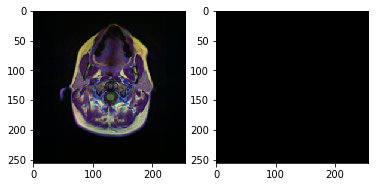

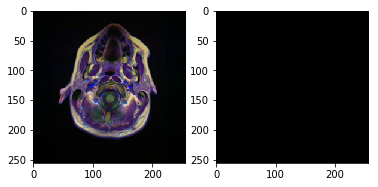

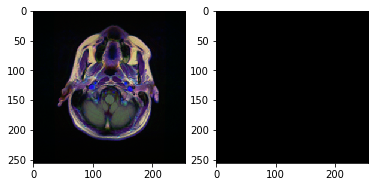

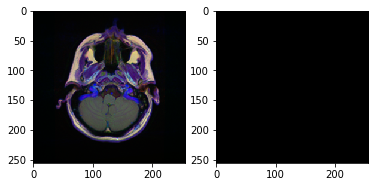

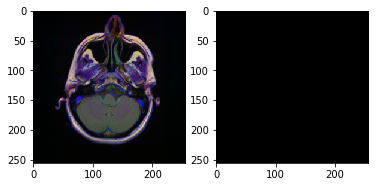

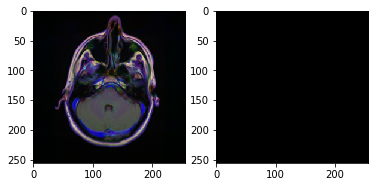

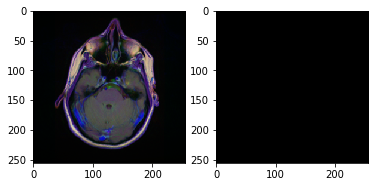

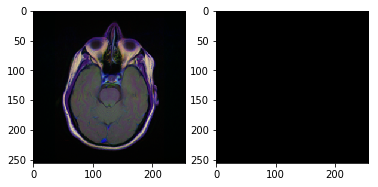

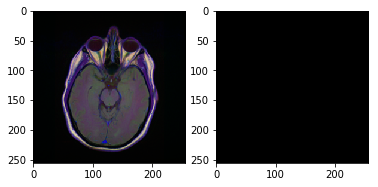

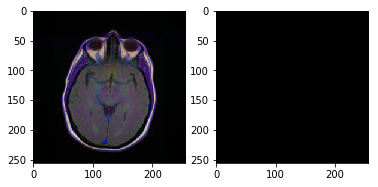

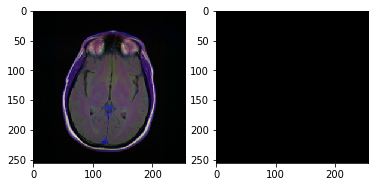

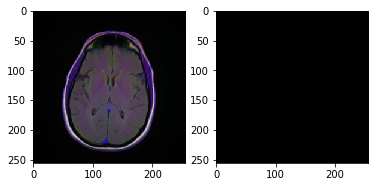

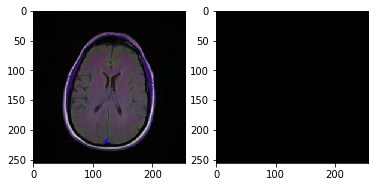

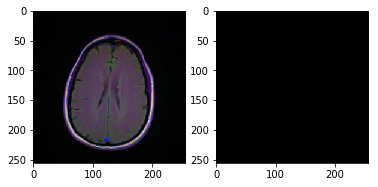

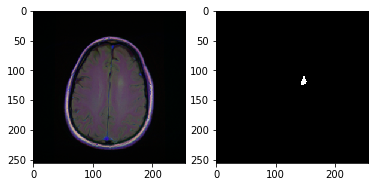

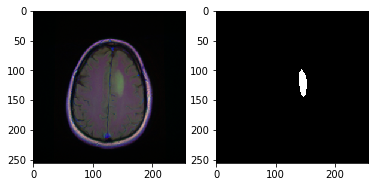

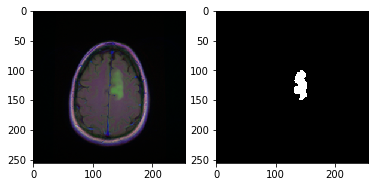

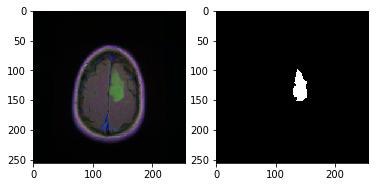

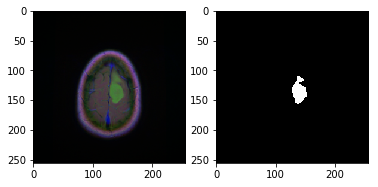

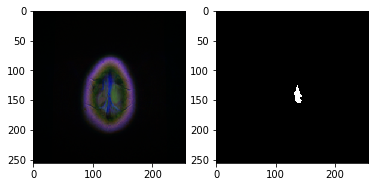

In [5]:
# visualize some data
dataset = BrainMRIDataset(root_dir, folders, 'val')

for i in range(20):
    
    img, mask = dataset[i]
    img = np.transpose(img, axes=(1,2,0))
    mask = np.squeeze(np.transpose(mask, axes=(1,2,0)))
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')

In [6]:
# unet model

class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(Unet, self).__init__()
        
        # encoder
        self.encoder1 = self.block(in_channels, init_features)
        self.pool1    = nn.MaxPool2d(2, 2)
        self.encoder2 = self.block(init_features, init_features*2)
        self.pool2    = nn.MaxPool2d(2, 2)
        self.encoder3 = self.block(init_features*2, init_features*4)
        self.pool3    = nn.MaxPool2d(2, 2)
#         self.encoder4 = self.block(init_features*4, init_features*8)
#         self.pool4    = nn.MaxPool2d(2, 2)
        
        # bottleneck
        self.bottleneck = self.block(init_features*4, init_features*8)
        
        # decoder
#         self.upconv4  = nn.ConvTranspose2d(init_features*16, init_features*8, kernel_size=2, stride=2)
#         self.decoder4 = self.block(init_features*16, init_features*8)
        self.upconv3  = nn.ConvTranspose2d(init_features*8, init_features*4, kernel_size=2, stride=2)
        self.decoder3 = self.block(init_features*8, init_features*4)
        self.upconv2  = nn.ConvTranspose2d(init_features*4, init_features*2, kernel_size=2, stride=2)
        self.decoder2 = self.block(init_features*4, init_features*2)
        self.upconv1  = nn.ConvTranspose2d(init_features*2, init_features, kernel_size=2, stride=2)
        self.decoder1 = self.block(init_features*2, init_features)
        
        self.conv = nn.Conv2d(init_features, out_channels, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
#         enc4 = self.encoder4(self.pool3(enc3))
        
        bottleneck = self.bottleneck(self.pool3(enc3))
        
#         dec4 = self.upconv4(bottleneck)
#         dec4 = torch.cat((dec4, enc4), dim=1)
#         dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.conv(dec1))    
        
            
    def block(self, in_channels, out_channels):
        return nn.Sequential(
                             nn.Conv2d(in_channels,
                                       out_channels,
                                       kernel_size=3,
                                       padding=1,
                                       bias=False),
                             nn.BatchNorm2d(out_channels),
                             nn.ReLU()
                            )
        

In [7]:
# device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [8]:
# create dataset objects
dataset = BrainMRIDataset(root_dir, folders, 'train')
dataset_val = BrainMRIDataset(root_dir, folders, 'val')

# split dataset to train val
patient_for_val = np.unique(dataset.patient_id)[30:50]
val_idxs = [i for i,x in enumerate(dataset.patient_id) if x in patient_for_val]

train_idxs = list(set(range(len(dataset.patient_id))) - set(val_idxs))

print("len(train_idxs): {} - len(val_idxs): {}".format(len(train_idxs), len(val_idxs)))

dataset = torch.utils.data.Subset(dataset, val_idxs)
dataset_val = torch.utils.data.Subset(dataset_val, train_idxs)

# dataloaders
data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=8, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(
                dataset_val, batch_size=8, shuffle=False)

# define model
unet = Unet()
unet.to(device).double()

# loss function
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(unet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# lr_scheduler 
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#train
num_epochs = 5


len(train_idxs): 3160 - len(val_idxs): 769


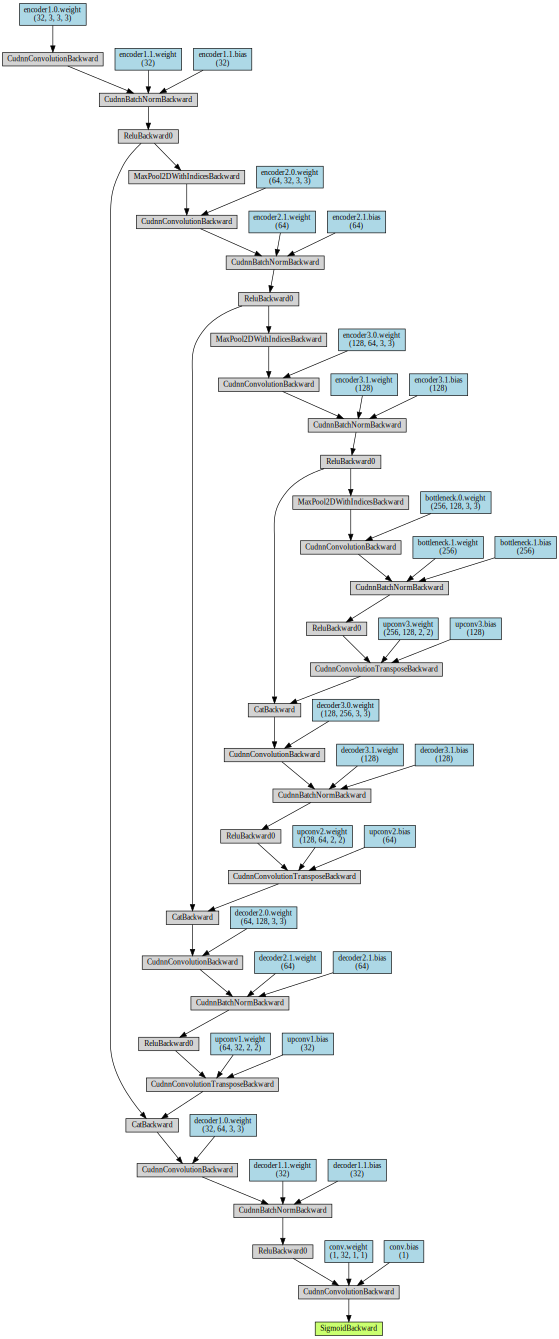

In [9]:
# visualize graph of model

from torchviz import make_dot, make_dot_from_trace

img, _ = dataset[15]
img = img.unsqueeze(0)
make_dot(unet(img.to(device)), params=dict(unet.named_parameters()))

In [10]:
# train and evaluate

best_val_loss = np.inf

best_model_fpath = 'model/bst_unet.model'

loss_train = []
loss_valid = []

for epoch in range(num_epochs):
    
    loss_train_temp = []
    loss_valid_temp = []

    for phase in ['train', 'val']:
        if phase == 'train':
            unet.train()
            loader = data_loader
        else:
            unet.eval()
            loader = data_loader_val

        for i, data in enumerate(loader):

            x, y_true = data
            x, y_true = x.to(device).double(), y_true.to(device).double()

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = unet(x)

                loss = criterion(y_pred, y_true)

                if phase == 'val':
                    loss_valid_temp.append(loss.item())
    
                if phase == 'train':
                    loss_train_temp.append(loss.item())
                    loss.backward()
                    optimizer.step()

        
        if phase == 'train':
            loss_train = np.mean(loss_train_temp)
            
        if phase == 'val':
            loss_valid = np.mean(loss_valid_temp)
            if loss_valid < best_val_loss:
                best_val_loss = loss_valid
    
    torch.save(unet.state_dict(), best_model_fpath)
    print('model saved/ epoch:{} / loss_valid:{}'.format(epoch, loss_valid))
    
    print('epoch:{} - loss_train:{} - loss_valid:{} '.format(epoch+1, loss_train, loss_valid))
    print('-'*50)
    

model saved/ epoch:0 / loss_valid:0.2985888545260888
epoch:1 - loss_train:0.4500017400599525 - loss_valid:0.2985888545260888 
--------------------------------------------------
model saved/ epoch:1 / loss_valid:0.17881261638164264
epoch:2 - loss_train:0.2338467202488657 - loss_valid:0.17881261638164264 
--------------------------------------------------
model saved/ epoch:2 / loss_valid:0.12451501628423593
epoch:3 - loss_train:0.1519952148223871 - loss_valid:0.12451501628423593 
--------------------------------------------------
model saved/ epoch:3 / loss_valid:0.09632943309551249
epoch:4 - loss_train:0.11374767473346883 - loss_valid:0.09632943309551249 
--------------------------------------------------
model saved/ epoch:4 / loss_valid:0.0829559272478185
epoch:5 - loss_train:0.09186225243797336 - loss_valid:0.0829559272478185 
--------------------------------------------------


torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256, 3])
torch.Size([256, 256])
torch.Size([256

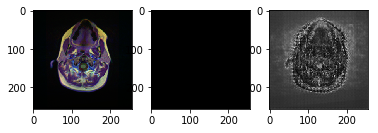

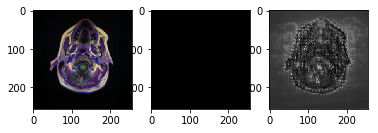

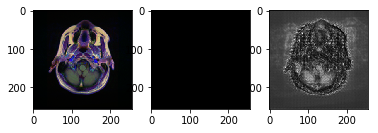

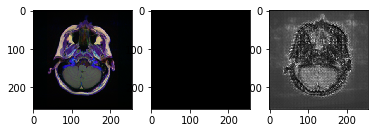

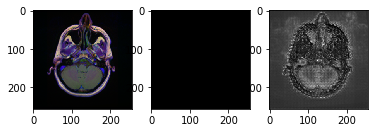

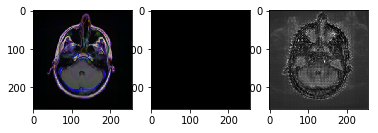

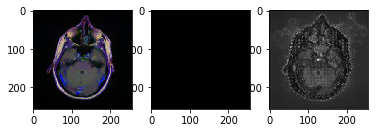

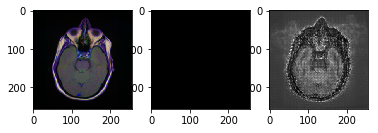

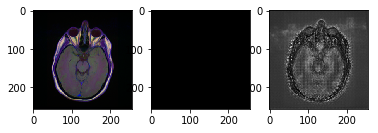

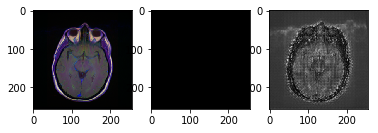

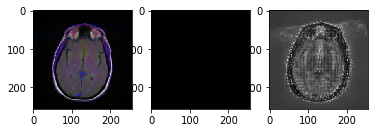

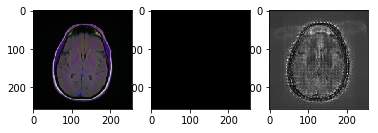

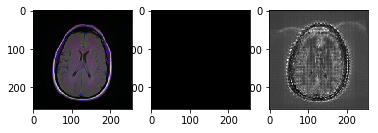

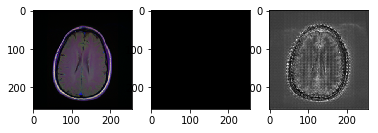

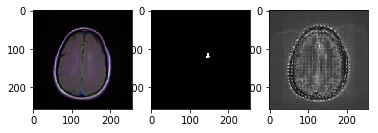

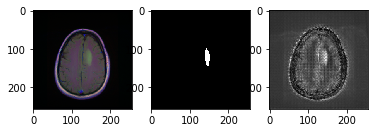

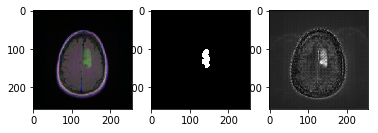

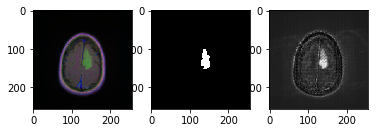

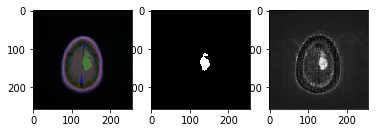

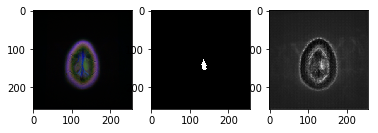

In [29]:
# pred

unet.eval()

for i in range(20):
    
    x, y_true = dataset_val[i]
    x = x.to(device).double()
    
    with torch.set_grad_enabled(False):
        y_pred = torch.squeeze(unet(torch.as_tensor(np.expand_dims(x.cpu(), axis=0)).to(device)), dim=0)
        
        img = np.transpose(x.cpu(), axes=(1, 2, 0))
        y_pred = np.squeeze(np.transpose(y_pred.cpu(), axes=(0, 1, 2)))
        y_true = np.squeeze(np.transpose(y_true, axes=(0, 1, 2)))
        
        
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.imshow(y_true, cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(y_pred, cmap='gray')